In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                      images/
__pycache__/                   jobs/
algorithm_compare_results/     models/
deeplifting/                   requirements.txt
deeplifting.png                results/
high-dimension-paper-results/  search_results/
high-dimension-search_results/ tasks.py


In [4]:
import glob as glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
file_directory = './algorithm_compare_results/low-dimensional/*/*'
files = glob.glob(file_directory)
files

['./algorithm_compare_results/low-dimensional/2023-09-14-17-levy/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-drop_wave/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-18-alpine2/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-shubert/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-xinsheyang_n3/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-ackley2/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-ackley3/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-xinsheyang_n2/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-bukin_n2/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-17-bohachevsky1/low-dimensional.parquet',
 './algorithm_compare_results/low-dimension

In [6]:
len(files)

39

In [7]:
# Load in the data
data = pd.read_parquet(files)
data.head()

,x1,x2,f,algorithm,time,problem_name,hits,dimensions
0,1.0,-0.092994,8.952825e-02,IPOPT,0.023972,levy,0,2
1,1.0,1.000000,3.917161e-17,IPOPT,0.043746,levy,1,2
2,1.0,1.000000,2.982301e-17,IPOPT,0.036035,levy,1,2
3,1.0,1.000000,2.975505e-17,IPOPT,0.017816,levy,1,2
4,1.0,1.000000,3.018360e-17,IPOPT,0.024534,levy,1,2


In [8]:
data['algorithm'].unique()

array(['IPOPT', 'Dual Annealing', 'Differential Evolution', 'PyGRANSO',
       'SCIP'], dtype=object)

In [9]:
# Let's look at shubert
data.loc[data['problem_name'] == 'alpine2']

,x1,x2,f,algorithm,time,problem_name,hits,dimensions
100,4.815842e+00,4.815842e+00,-4.764484e+00,IPOPT,0.033192,alpine2,0,2
101,4.815842e+00,4.815842e+00,-4.764484e+00,IPOPT,0.021691,alpine2,0,2
102,4.282365e+00,1.732642e-08,4.289905e-12,IPOPT,0.047652,alpine2,0,2
103,4.815842e+00,4.815842e+00,-4.764484e+00,IPOPT,0.014156,alpine2,0,2
104,1.000000e+01,4.815842e+00,-3.755119e+00,IPOPT,0.021300,alpine2,0,2
105,1.836597e+00,7.917053e+00,-3.671967e+00,IPOPT,0.018132,alpine2,0,2
106,7.917053e+00,1.836597e+00,-3.671967e+00,IPOPT,0.015640,alpine2,0,2
107,1.836597e+00,7.917053e+00,-3.671967e+00,IPOPT,0.022678,alpine2,0,2
108,7.917053e+00,7.917053e+00,-7.885601e+00,IPOPT,0.024266,alpine2,1,2
109,1.553092e-08,5.030809e+00,4.123020e-12,IPOPT,0.053347,alpine2,0,2


In [10]:
x1, x2 = 10, -3
100 * (x2 - 0.01 * np.square(x1) + 1) + 0.01 * np.square(x1 + 10)

-296.0

In [11]:
aggregate_dict = {'hits': ['mean'], 'time': 'mean'}

# We want to group this data by
# problem name
# algorithm
# attributions are f, hits and time
results = data.groupby(['problem_name', 'algorithm', 'dimensions']).agg(aggregate_dict)

results.columns = ['-'.join(column) for column in results.columns]
results = results.rename(columns={'hits-mean': 'Success Rate'}).reset_index()

algorithm_map = {
    'Differential Evolution': 'DE',
    'Dual Annealing': 'DA',
    'IPOPT': 'IPOPT',
    'PyGRANSO': 'PyGRANSO',
    'SCIP': 'SCIP',
}
results['algorithm'] = results['algorithm'].map(algorithm_map)
results

,problem_name,algorithm,dimensions,Success Rate,time-mean
0,ackley,DE,2,1.0,0.405362
1,ackley,DA,2,1.0,0.795759
2,ackley,IPOPT,2,0.0,0.026824
3,ackley,PyGRANSO,2,0.0,0.144548
4,ackley,SCIP,2,1.0,0.039031
...,...,...,...,...,...
190,xinsheyang_n3,DE,2,1.0,0.070390
191,xinsheyang_n3,DA,2,1.0,0.755376
192,xinsheyang_n3,IPOPT,2,0.6,1.162287
193,xinsheyang_n3,PyGRANSO,2,0.1,0.194460


In [12]:
# Let's try a heat map to look at all problems
hits_df = results.pivot_table(
    index='problem_name', columns='algorithm', values='Success Rate'
)

In [13]:
hits_df.mean()

algorithm
DA          0.902564
DE          0.856410
IPOPT       0.456410
PyGRANSO    0.407692
SCIP        0.948718
dtype: float64

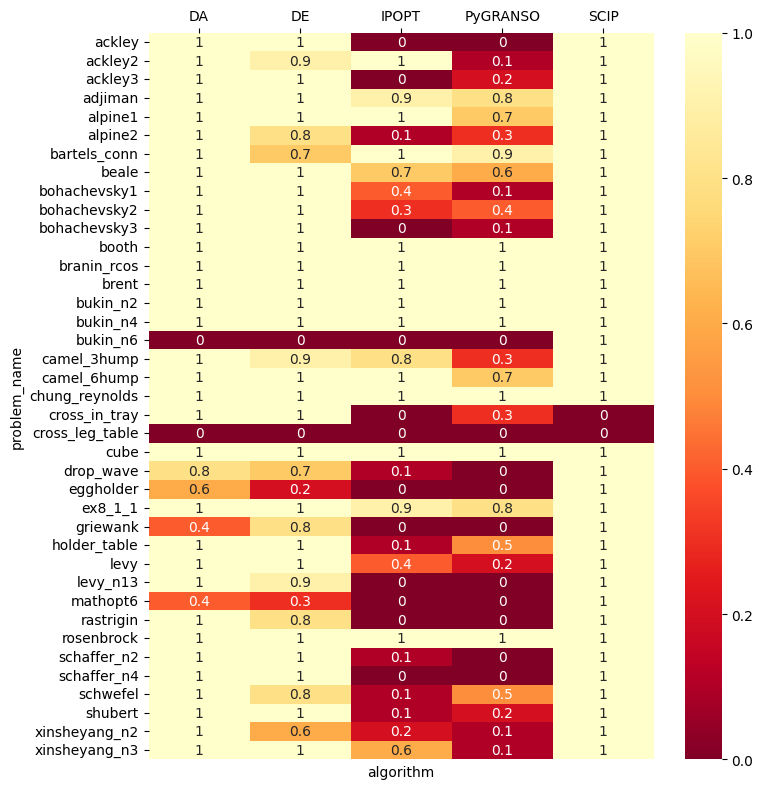

In [14]:
# YlOrRd_r

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

sns.heatmap(data=hits_df, annot=True, cmap='YlOrRd_r', ax=ax1)
ax1.xaxis.tick_top()

fig.tight_layout()